# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

# adaboost method for learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")




# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.channels.head(10)

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

It has ten offers which have six features including _channels_, _difficulty_, _duration_, _id_, _offer_type_, and _reward_. Keep in mind the "informational" in offer_type gives no wards to incentive customers. 

In [5]:
portfolio.iloc[portfolio.reward.sort_values(ascending = False).index]

,channels,difficulty,duration,id,offer_type,reward
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [6]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

Encode *id* into *offer_id* to the range of [1,10]

In [7]:
from sklearn.preprocessing import LabelEncoder
portfolio_df = portfolio.copy()
offer_encoder = LabelEncoder()
portfolio_df['offer_id'] = offer_encoder.fit_transform(portfolio_df['id'])

portfolio_df.sort_values(by = 'offer_id')


,channels,difficulty,duration,id,offer_type,reward,offer_id
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,3
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,4
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,5
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,6
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,8
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,9


**Profile** data has customers's age, the date *became_member_on*, _gender_, and _id_ with _income_. It also contains some missing values.

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
len(profile.id.unique())

17000

__"gender" and "income" colulmns has about 12.7% null values__
- Both seems to have the same percentage of missing values. It's highly possible that both missing values co-exist on the same user "id"

In [11]:
#percentate of null in each column
profile.isnull().sum()/len(profile)

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [12]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
len(profile[profile['income'].isnull()].gender.isnull())

2175

The null value of income and gender share the same rows
The age inside the row of null values of income and gender seems to be the same value as 118. 
Common sense tells us those null values rows may be erroneous.


In [14]:
profile[profile['income'].isnull()].age.head()

0    118
2    118
4    118
6    118
7    118
Name: age, dtype: int64

In [15]:
len(profile[profile['income'].isnull()].age)

2175

In [16]:
profile_df = profile.copy()
person_encoder = LabelEncoder()
profile_df['per_id'] = person_encoder.fit_transform(profile_df['id'])
profile_df.head()

,age,became_member_on,gender,id,income,per_id
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,6961
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,398
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,3746
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,7996
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,10735


In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript_df = transcript.copy()

Encode _person_ into *per_id*. This encoder will use in the **Transcript** data later

In [19]:
transcript_df['per_id'] = person_encoder.transform(transcript_df['person'])
transcript_df.head()

,event,person,time,value,per_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},10735
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},15043
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},9524
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},6939


The "age" in all of the "null" values of *income* and *gender* is **118**, which seems to be a meaningless value.
Those missing values could be filled with predicted value by using machine learning techniques as _[in this article](https://towardsdatascience.com/implementing-a-profitable-promotional-strategy-for-starbucks-with-machine-learning-part-1-2f25ec9ae00c)_, but now I just drop all of them for the convinience.

In [20]:
transcript_df.head(20)

,event,person,time,value,per_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},10735
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},15043
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},9524
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},6939
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},3728
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},13108
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3059
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},11410
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},3274


In [21]:
#percentate of null in each column
transcript_df.isnull().sum()/len(profile)

event     0.0
person    0.0
time      0.0
value     0.0
per_id    0.0
dtype: float64

In [22]:
transcript_df.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

"Offer completed" takes up 11% of __Transcript__ data

In [23]:
len(transcript_df[transcript_df['event'] == 'offer completed'])/len(transcript_df)

0.10954412887314295

About 58% "offer completed" after "offer viewd" in general.

In [24]:
len(transcript_df[transcript_df['event'] == 'offer completed'])/len(transcript_df[transcript_df['event'] == 'offer viewed'])

0.5817063663923776

Show one customer's event with time as an example. Look deeper into one person's account in the transcript data, the value column has two different type of information: 1. {'offer id': value} and 2 {'amount': value}. Here, the person has been encoded by creating a new column named per_id and used the per_id encoder from the Profile data

In [25]:
transcript_df[transcript_df['person'] =='78afa995795e4d85b5d9ceeca43f5fef' ].sort_values(by = ['time'])

,event,person,time,value,per_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},7996
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,7996
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},7996
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},7996
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},7996
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},7996
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},7996
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},7996


Two types of infomration in _value_ column has been separated by keys and values.

In [26]:

transcript_df['value_type'] = transcript_df['value'].apply(lambda x : list(x.keys())[0])
transcript_df['value_amt'] = transcript_df['value'].apply(lambda x : list(x.values())[0])


In [27]:
transcript_df.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Dataframe **transcript_df_offer_type** is created for "offer_id"

In [28]:
transcript_df_offer_type = transcript_df[(transcript_df['value_type']==('offer_id') )|( transcript_df['value_type']==('offer id'))]

In [29]:
transcript_df_offer_type.head()

,event,person,time,value,per_id,value_type,value_amt
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},10735,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},15043,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},9524,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},6939,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


Create column *offer_id* by encoding the values in *value_amt* using the offer_encoder in the **Portfolio**

In [30]:
transcript_df_offer_type['offer_id'] = offer_encoder.transform(transcript_df_offer_type['value_amt'])

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
transcript_df_offer_type.head()

,event,person,time,value,per_id,value_type,value_amt,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,6
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},10735,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},15043,offer id,2906b810c7d4411798c6938adc9daaa5,2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},9524,offer id,fafdcd668e3743c1bb461111dcafc2a4,9
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},6939,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,4


Drop the column of  ['person','value','value_type','value_amt']

In [32]:
transcript_df_offer_type = transcript_df_offer_type.drop(columns = ['person','value','value_type','value_amt'])
transcript_df_offer_type.head()

,event,time,per_id,offer_id
0,offer received,0,7996,6
1,offer received,0,10735,0
2,offer received,0,15043,2
3,offer received,0,9524,9
4,offer received,0,6939,4


Create **transcript_df_amount** for transcation record 

In [33]:
transcript_df_amount = transcript_df[transcript_df['value_type']=='amount']

In [34]:
transcript_df_amount.head()

,event,person,time,value,per_id,value_type,value_amt
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},169,amount,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},10701,amount,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},5627,amount,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},11984,amount,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},16908,amount,18.97


In [35]:
transcript_df_amount =  transcript_df_amount.drop(columns = ['person','value','value_type'])

In [36]:
transcript_df_amount.head()

,event,time,per_id,value_amt
12654,transaction,0,169,0.83
12657,transaction,0,10701,34.56
12659,transaction,0,5627,13.23
12670,transaction,0,11984,19.51
12671,transaction,0,16908,18.97


## Feature Engineering and Offer Prediction Model ## 

### Offer type feature engineering ###

In [37]:
profile_df = profile_df.dropna()
profile_df = profile_df.drop(columns = 'id')
profile_df.isnull().sum()

age                 0
became_member_on    0
gender              0
income              0
per_id              0
dtype: int64

Firstly, a bar chart is generated to check the distribution of each offer type's status (offer received, offer viewed, and offer completed). This feature could be used as good indicator to gauge the offer's effectiveness. When a offer is delivered to a customer, a customer needs to have two actions to complete the offer. First, the offered needs to be viewed, then, the last key action is to complete the offer to purchase in Starbucks.

For a promotion offer, a customers might have already viewed or know some detail. of the offered even not "viewed" this offer because most of the offer viewed is counted by whether the customer click it or not. But most of offers sent digitally already have titles that indicate what kind of the offer is in some degree. So how many times in the offer viewed in comparison of the offer received infers how customer interest in this offer. By the same means, offer completed  is the final result of how customers are impact by the offer.

From this chart, it clearly frames the offers in three groups as
1. For informational offer (type 3 and 5), obviously, they don't have offer completed  due to they don't target needed to be complete.
2. Regarding offer types 0,2 and 6, the number of completion is higher or close to the number of views. It inferred those types of offer are not very effective to motivate customers to purchase. Even though in type 2 the offer_completed is slightly higher than the offer viewed, but the offer viewed is much less than the offer received, which indicate this offer has less responsive for customers. 
3. Types 1,4,7,8, and 9 are highly possible to be more effective offers.

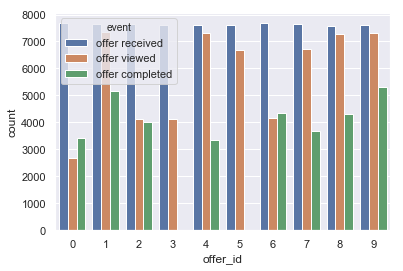

In [38]:
ax = sns.countplot(x="offer_id", hue="event", data=transcript_df_offer_type)

To gauge the effectiveness of conversion of offer by the customers, two new features have been created as: (view_conv_rate = offer_viewed / offer_received)  and (complete_conv_rate = offer completed /offer received).

User offer_id = 1 as an example to dig into the offer detail

**transcript_df_offer_type_1** is built for offer type 1

In [39]:
transcript_df_offer_type_1 = transcript_df_offer_type[transcript_df_offer_type['offer_id']==1]

In [40]:
transcript_df_offer_type_1 = transcript_df_offer_type_1.groupby(['per_id','event'])['event'].count().unstack().fillna(0)

In [41]:
transcript_df_offer_type_1 = pd.DataFrame(index =transcript_df_offer_type_1.index,\
                                          data =transcript_df_offer_type_1.values, \
                                          columns = ["offer_completed","offer_received","offer_viewed"])

In [42]:
transcript_df_offer_type_1.head()

,offer_completed,offer_received,offer_viewed
per_id,,,
2,1.0,1.0,1.0
4,1.0,1.0,1.0
10,1.0,1.0,1.0
11,0.0,1.0,1.0
19,0.0,1.0,1.0


In [43]:
transcript_df_offer_type_1['view_conv_rate'] = transcript_df_offer_type_1['offer_viewed']/transcript_df_offer_type_1['offer_received']

In [44]:
transcript_df_offer_type_1['complete_conv_rate'] = transcript_df_offer_type_1['offer_completed']/transcript_df_offer_type_1['offer_received']

In [45]:
transcript_df_offer_type_1 = transcript_df_offer_type_1[['offer_received','offer_viewed',"offer_completed","view_conv_rate",'complete_conv_rate']]

In [46]:
transcript_df_offer_type_1.head()

,offer_received,offer_viewed,offer_completed,view_conv_rate,complete_conv_rate
per_id,,,,,
2,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.0
11,1.0,1.0,0.0,1.0,0.0
19,1.0,1.0,0.0,1.0,0.0


Here, the __effective__ of offer for the targeted customer is defined as such:  in one offer type,  this offer's effective equals one if a customer's view_conv_rate  is 1 and complete_conv_rate is 1. Otherwise, the effective is zero.

In [47]:
transcript_df_offer_type_1['effective'] = transcript_df_offer_type_1['offer_completed'].\
                                      apply(lambda x: 1 if x>0 else 0)

transcript_df_offer_type_1['view_bl'] = transcript_df_offer_type_1['offer_viewed'].\
                                      apply(lambda x: 1 if x>0 else 0)

transcript_df_offer_type_1['effective'] = \
                transcript_df_offer_type_1['effective'] * transcript_df_offer_type_1['view_bl']

transcript_df_offer_type_1 = transcript_df_offer_type_1.drop('view_bl',axis = 1)

In [48]:
transcript_df_offer_type_1.head()

,offer_received,offer_viewed,offer_completed,view_conv_rate,complete_conv_rate,effective
per_id,,,,,,
2,1.0,1.0,1.0,1.0,1.0,1
4,1.0,1.0,1.0,1.0,1.0,1
10,1.0,1.0,1.0,1.0,1.0,1
11,1.0,1.0,0.0,1.0,0.0,0
19,1.0,1.0,0.0,1.0,0.0,0


Define a offer_group function to create each offer's effectiveness

In [49]:
# define the offer_group function
def offer_group(group_type,transcript_df_offer_type,profile_df):
    transcript_df_offer_group = transcript_df_offer_type[transcript_df_offer_type['offer_id']==group_type]
    transcript_df_offer_group = transcript_df_offer_group.groupby(['per_id','event'])['event'].count().unstack().fillna(0)
    transcript_df_offer_group = pd.DataFrame(index =transcript_df_offer_group.index,\
                                          data =transcript_df_offer_group.values, \
                                          columns = ["offer_completed","offer_received","offer_viewed"])
    transcript_df_offer_group['view_conv_rate'] = \
    transcript_df_offer_group['offer_viewed']/transcript_df_offer_group['offer_received']
    
    transcript_df_offer_group['complete_conv_rate'] = \
    transcript_df_offer_group['offer_completed']/transcript_df_offer_group['offer_received']
    
    
    
    transcript_df_offer_group = \
    transcript_df_offer_group[['offer_received','offer_viewed',"offer_completed","view_conv_rate",'complete_conv_rate']]
    transcript_df_offer_group['effective'] = transcript_df_offer_group['view_conv_rate'].\
                                      apply(lambda x: 1 if x>=1 else 0)
    transcript_df_offer_group['view_bl'] = transcript_df_offer_group['complete_conv_rate'].\
                                      apply(lambda x: 1 if x>=1 else 0)
    
    transcript_df_offer_group['effective'] = transcript_df_offer_group['effective'] * transcript_df_offer_group['view_bl']
    
    transcript_df_offer_group = transcript_df_offer_group.drop('view_bl',axis = 1)
    
    transcript_df_offer_group = transcript_df_offer_group[transcript_df_offer_group.index.isin(profile_df.index)]
    
    return transcript_df_offer_group

## Predictive Model 

As summarized above  types 1,4,7,8, and 9 are finally selected as the offers targeted to the customers for this model.

A predictive model is to be built by combining the offer table with customer's **Profile** table within the same offer id. As shown below, so customer's age, gender and income are used to predict the effective of the offer.

In [50]:

transcript_df_offer_type_1 = offer_group(1,transcript_df_offer_type,profile_df)
transcript_df_offer_type_4 = offer_group(4,transcript_df_offer_type,profile_df)
transcript_df_offer_type_7 = offer_group(7,transcript_df_offer_type,profile_df)
transcript_df_offer_type_8 = offer_group(8,transcript_df_offer_type,profile_df)
transcript_df_offer_type_9 = offer_group(9,transcript_df_offer_type,profile_df)

In [51]:
#save those dataframes in pickle
transcript_df_offer_type_1.to_pickle("transcript_df_offer_type_1.pkl")
transcript_df_offer_type_4.to_pickle("transcript_df_offer_type_4.pkl")
transcript_df_offer_type_7.to_pickle("transcript_df_offer_type_7.pkl")
transcript_df_offer_type_8.to_pickle("transcript_df_offer_type_8.pkl")
transcript_df_offer_type_9.to_pickle("transcript_df_offer_type_9.pkl")

Uer **Type 1 offer** as the example for the model test 

In [52]:
offer_type_1_data= transcript_df_offer_type_1.join(profile_df)

In [53]:
offer_type_1_data = offer_type_1_data.drop(['offer_received','offer_viewed','became_member_on'],axis = 1)

In [54]:
offer_type_1_data['gender'] = offer_type_1_data['gender'].apply(lambda x: 1 if x is 'M' else 0)

In [55]:
offer_type_1_data[['age','gender','income','effective']].head(20)

,age,gender,income,effective
per_id,,,,
19,61,0,40000.0,0
21,64,1,100000.0,0
24,42,1,69000.0,1
32,22,1,70000.0,1
33,96,0,89000.0,0
34,40,1,33000.0,1
38,26,0,63000.0,1
40,75,1,40000.0,0
42,45,1,33000.0,0


In [75]:
len(offer_type_1_data[offer_type_1_data['effective'] ==1])/len(offer_type_1_data)

0.6303956834532374

In [56]:
X = offer_type_1_data[['age','gender','income']]

In [57]:
y = offer_type_1_data['effective']
y.head()

per_id
19    0
21    0
24    1
32    1
33    0
Name: effective, dtype: int64

In [58]:
X.head()

,age,gender,income
per_id,,,
19,61,0,40000.0
21,64,1,100000.0
24,42,1,69000.0
32,22,1,70000.0
33,96,0,89000.0


In [59]:
from sklearn.preprocessing import MinMaxScaler
age_scaler = MinMaxScaler()
X['age'] = age_scaler.fit_transform(X['age'].values.reshape(-1, 1))
X.head()

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,gender,income
per_id,,,
19,0.518072,0,40000.0
21,0.554217,1,100000.0
24,0.289157,1,69000.0
32,0.048193,1,70000.0
33,0.939759,0,89000.0


In [60]:
income_scaler = MinMaxScaler()
X['income'] = income_scaler.fit_transform(X['income'].values.reshape(-1, 1))
X.head()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,income
per_id,,,
19,0.518072,0,0.111111
21,0.554217,1,0.777778
24,0.289157,1,0.433333
32,0.048193,1,0.444444
33,0.939759,0,0.655556


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [62]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100,
                         learning_rate=1,
                        random_state  = 42)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

### Metrics for evaluation model

$accuracy = (TP + TN) /(TP + TN + FN + FP)$

Accuracy alone has limitations as an evaluation metric, particularly when the positive class is much smaller than the negative class. Consider the development of a classiﬁer to diagnose whether an email is spam, where the positive class is spam and the negative class is not spam. The prior distribution is that the vast majority of people not spam. 

Suppose that only 5% of the emails are really spam. It still achieves 95% of accuracy when the classifier claims all emails are not spam.



So more balance matrics should consider:

**precision**

$precision = TP  /(TP + FP)$

**recall**

$recall = TP /(TP + FN)$

**F score**

$ F = 2* (recall * precision)/(recall + precision)$


In [63]:
print("f1_score:",metrics.f1_score(y_test, y_pred))

f1_score: 0.7747415066469718


It can show that the _gender_ has the less importance customer's feature. _Age_ and _inocme_ are alsmot at the same level.

In [64]:
importances = abc.feature_importances_

In [65]:
importances

array([0.59, 0.01, 0.4 ])

### Prediction by Grid Search with AdaBoost

**Grid Search** method is used to get optimal parameters by using **roc_auc** as the scoring metric. **AdaBoost** method as the classifier of the offer effective. Sample codes as blow:

In [83]:
def offer_predict(offer_type,profile_df):
    offer_type= offer_type.join(profile_df)
    offer_type = offer_type.drop(['offer_received','offer_viewed','offer_completed',\
                                                'became_member_on'],axis = 1)
    offer_type['gender'] = offer_type['gender'].apply(lambda x: 1 if x is 'M' else 0)
    X = offer_type[['age','gender','income']]
    y = offer_type['effective']
    
    income_scaler = MinMaxScaler()
    X['income'] = income_scaler.fit_transform(X['income'].values.reshape(-1, 1))
    
    age_scaler = MinMaxScaler()
    X['age'] = age_scaler.fit_transform(X['age'].values.reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "n_estimators": [50, 100, 150],
                  "learning_rate":[0.5,0.7,1.0]
             }


    DTC = DecisionTreeClassifier(random_state = 42)

    abc = AdaBoostClassifier(base_estimator = DTC)

    # run grid search
    grid_search_abc = GridSearchCV(abc, param_grid=param_grid, scoring = 'f1')
    grid_search_abc.fit(X_train, y_train)
    predictions_train = grid_search_abc.predict(X_train)
    y_pred = grid_search_abc.predict(X_test)
    # Create adaboost classifer object
    
    #abc = AdaBoostClassifier(n_estimators=100,
     #                    learning_rate=0.5,
      #                  random_state  = 42)
    
    # Train Adaboost Classifer
    #model = abc.fit(X_train, y_train)

    #Predict the response for test dataset
    #predictions_train = model.predict(X_train)
    #y_pred = model.predict(X_test)
    
    
    f1_pred = metrics.f1_score(y_test, y_pred)
    
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,y_pred))
    print("F1_predict: %.4f" % f1_pred)
    #print(classification_report(y_test, y_pred,digits=4))
    print("roc_auc_score: %.4f" %roc_auc_score(y_test, y_pred))

    return f1_pred,roc_auc_score
    
    

Run for the offer Type 1,4,7,8,9

In [84]:
offer_predict(transcript_df_offer_type_1,profile_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
E:\ProgramData\Anaconda3\lib\site-p

MSE_train: 0.0897
MSE_test: 0.4580
F1_predict: 0.6463
roc_auc_score: 0.4991


(0.6462962962962963,
 <function sklearn.metrics.ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None)>)

In [79]:
offer_predict(transcript_df_offer_type_4,profile_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
E:\ProgramData\Anaconda3\lib\site-p

MSE_train: 0.0875
MSE_test: 0.4806
F1_predict: 0.3707
roc_auc_score: 0.4944


(0.37072394590294355,
 <function sklearn.metrics.ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None)>)

In [80]:
offer_predict(transcript_df_offer_type_7,profile_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
E:\ProgramData\Anaconda3\lib\site-p

MSE_train: 0.0882
MSE_test: 0.4638
F1_predict: 0.4155
roc_auc_score: 0.5156


(0.4155455904334828,
 <function sklearn.metrics.ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None)>)

In [81]:
offer_predict(transcript_df_offer_type_8,profile_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
E:\ProgramData\Anaconda3\lib\site-p

MSE_train: 0.0910
MSE_test: 0.5034
F1_predict: 0.5162
roc_auc_score: 0.4959


(0.516166960611405,
 <function sklearn.metrics.ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None)>)

In [82]:
offer_predict(transcript_df_offer_type_9,profile_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
E:\ProgramData\Anaconda3\lib\site-p

MSE_train: 0.0863
MSE_test: 0.4455
F1_predict: 0.6723
roc_auc_score: 0.4921


(0.6723138653588943,
 <function sklearn.metrics.ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None)>)